## Описание проекта

«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов

Тариф «Смарт»

Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»

Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей



## Шаг 1. Обзор данных

In [3]:
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math
import warnings
warnings.filterwarnings("ignore")

In [4]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

Загрузили 5 датасетов, т.к. их колчиество большое, то удобнее будет рассмотреть каждый в отдельности во 2 шаге

## Шаг 2. Подготовка данных

###  users

In [5]:
users.tail()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
499,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Из информации выше видим, что у нас есть пропуски в столбце churn_date, но в данных к работе указано, что пропуски означают, что тарифом еще пользуются. Трогать этот столбец не будем.
Изменим данные reg_date в формат datetime, так же проверим все ли данные за 2018 год и удалим колонки, которые дальше нам не пригодятся для исследования

In [7]:
users['reg_date'] = pd.to_datetime(users['reg_date'],
format='%Y-%m-%d')

In [8]:
users['churn_date'] = pd.to_datetime(users['churn_date'],
format='%Y-%m-%d')

In [9]:
users['reg_date'].dt.year.unique()

array([2018])

In [10]:
users['reg_date'] = users['reg_date'].to_numpy().astype('datetime64[M]')
users['churn_date'] = users['churn_date'].to_numpy().astype('datetime64[M]')

In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [12]:
min_dt = users['reg_date'].min()

In [13]:
max_dt = users['reg_date'].max()

In [14]:
table = pd.DataFrame(pd.date_range(min_dt, max_dt,freq='MS'))

In [15]:
table.columns = ['month']

In [16]:
table

,month
0,2018-01-01
1,2018-02-01
2,2018-03-01
3,2018-04-01
4,2018-05-01
5,2018-06-01
6,2018-07-01
7,2018-08-01
8,2018-09-01
9,2018-10-01


In [17]:
table['key'] = 1

In [18]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-01,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-01,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-01,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-01,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-01,ultra
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-01,smart
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-01,smart
498,1498,68,2018-10-01,Владикавказ,Всеволод,Акимчин,2018-07-01,smart


In [19]:
user_reg = users[['user_id', 'reg_date','churn_date']]

In [20]:
user_reg['key'] = 1

In [21]:
template = table.merge(user_reg, on='key')[['month', 'user_id', 'reg_date', 'churn_date']]

In [22]:
template

,month,user_id,reg_date,churn_date
0,2018-01-01,1000,2018-05-01,NaT
1,2018-01-01,1001,2018-11-01,NaT
2,2018-01-01,1002,2018-06-01,NaT
3,2018-01-01,1003,2018-08-01,NaT
4,2018-01-01,1004,2018-05-01,NaT
...,...,...,...,...
5995,2018-12-01,1495,2018-08-01,NaT
5996,2018-12-01,1496,2018-01-01,NaT
5997,2018-12-01,1497,2018-10-01,NaT
5998,2018-12-01,1498,2018-07-01,2018-10-01


In [23]:
template['churn_date'] = template['churn_date'].fillna('2018-12-01').to_numpy().astype('datetime64[M]')

In [24]:
template = template[template['month'] >= template['reg_date']]
template = template[template['month'] <= template['churn_date']]

In [25]:
template[template['user_id'] == 1498]

,month,user_id,reg_date,churn_date
3498,2018-07-01,1498,2018-07-01,2018-10-01
3998,2018-08-01,1498,2018-07-01,2018-10-01
4498,2018-09-01,1498,2018-07-01,2018-10-01
4998,2018-10-01,1498,2018-07-01,2018-10-01


In [26]:
template = template[['month', 'user_id']]

Сформировали таблицу template с актуальными месяцами по каждому юзеру с момента его регистрации до отключения от тарифа(если оно присуствует) для дальнейшего корректного объеденения таблиц

In [27]:
template.head()

,month,user_id
5,2018-01-01,1005
32,2018-01-01,1032
45,2018-01-01,1045
55,2018-01-01,1055
71,2018-01-01,1071


In [28]:
users.drop(columns=['age','first_name', 'last_name', 'churn_date', 'reg_date'], axis = 1, inplace=True)

In [29]:
users

,user_id,city,tariff
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart
3,1003,Москва,ultra
4,1004,Новокузнецк,ultra
...,...,...,...
495,1495,Иркутск,ultra
496,1496,Вологда,smart
497,1497,Челябинск,smart
498,1498,Владикавказ,smart


### messages

In [30]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [31]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Пропусков у нас в таблице с смс не обнаружено, изменим тип данных message_date на datetime

In [32]:
messages['message_date'] = pd.to_datetime(messages['message_date'],
format='%Y-%m-%d')

In [33]:
messages['month'] = messages['message_date'].to_numpy().astype('datetime64[M]')

Изменяем тип столбца month, преобразования делаем с помощью astype('datetime64[M]')
Такие же изменения произведены с данными интерента и звонков

In [34]:
messages_count = messages.groupby(['user_id','month'],as_index=False)['id'].count()
messages_count.columns = ['user_id', 'month', 'messages_count']  

In [35]:
messages_count.head()

,user_id,month,messages_count
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57


Создали таблицу с количеством смс каждого пользователя по месяцам

### internet

In [36]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [37]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Так же пропусков нет, поменяем тип session_date на datetime

In [38]:
internet['session_date'] = pd.to_datetime(internet['session_date'],
format='%Y-%m-%d')

In [39]:
internet['month'] = internet['session_date'].to_numpy().astype('datetime64[M]')

In [40]:
internet_sum = internet.groupby(['user_id','month'],as_index=False)['mb_used'].sum()

In [41]:
internet_sum

,user_id,month,mb_used
0,1000,2018-05-01,2253.49
1,1000,2018-06-01,23233.77
2,1000,2018-07-01,14003.64
3,1000,2018-08-01,14055.93
4,1000,2018-09-01,14568.91
...,...,...,...
3198,1498,2018-10-01,20579.36
3199,1499,2018-09-01,1845.75
3200,1499,2018-10-01,17788.51
3201,1499,2018-11-01,17963.31


Создали таблицу с подсчетом израсходанного трафика мб интернета по каждому пользователю в каждый месяц

In [42]:
internet_sum['mb_used'] = np.ceil(internet_sum['mb_used']/1024).astype('int')

In [43]:
internet_sum = internet_sum.rename(columns={'mb_used':'gb_used'})

Т.к. оператор округляет в большую сторону количество израсходаного трафига, то сначала переведем мб в гигабайты и округлим в большую сторону, приведем данные к целому числу. 

### calls

In [44]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [45]:
calls.tail()

,id,call_date,duration,user_id
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499
202606,1499_219,2018-12-14,19.62,1499


Пропусков данных нет, поменяем call_date в тип datetime и округлим значение duration в большую сторону. И приведем к целому числу, т.к. оператор считает за использование минуты, даже если звонок был завершен ранее.

In [46]:
calls['duration'] = calls['duration'].apply(math.ceil)

In [47]:
calls.tail()

,id,call_date,duration,user_id
202602,1499_215,2018-12-26,1,1499
202603,1499_216,2018-10-18,19,1499
202604,1499_217,2018-11-10,11,1499
202605,1499_218,2018-10-06,5,1499
202606,1499_219,2018-12-14,20,1499


In [48]:
calls['call_date'] = pd.to_datetime(calls['call_date'],
format='%Y-%m-%d')

In [49]:
calls['month'] = calls['call_date'].to_numpy().astype('datetime64[M]')

In [50]:
calls_count_sum = calls.groupby(['user_id','month'])['duration'].agg(['sum', 'count']).reset_index()
calls_count_sum.columns = ['user_id', 'month', 'calls_sum', 'calls_count']

In [51]:
calls_count_sum

,user_id,month,calls_sum,calls_count
0,1000,2018-05-01,159,22
1,1000,2018-06-01,172,43
2,1000,2018-07-01,340,47
3,1000,2018-08-01,408,52
4,1000,2018-09-01,466,58
...,...,...,...,...
3169,1498,2018-10-01,247,41
3170,1499,2018-09-01,70,9
3171,1499,2018-10-01,449,68
3172,1499,2018-11-01,612,74


Получили таблицу с данными о количесте звонков и количестве израсходованных минут каждого пользователя.

### tariffs

In [52]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Здесь у нас таблица с информацией по каждому тарифу, переведем mb_per_month_included в гигабайты, т.к. выше мы посчитали трафик в гигабайтах. Для дальнейшего сравнения так будет удобнее.
И переименуем столбцы

In [53]:
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included']/1024

In [54]:
tariffs = tariffs.rename(columns={
    'mb_per_month_included':'gb_per_month_included', 
    'tariff_name':'tariff'})

In [55]:
tariffs

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15.0,500,550,200,3,3,smart
1,1000,30.0,3000,1950,150,1,1,ultra


### Объединение таблиц

In [57]:
data = template.merge(internet_sum, on=('user_id','month'), how='outer')
data = data.merge(calls_count_sum, on=('user_id','month'), how='outer')
data = data.merge(messages_count, on=('user_id','month'), how='outer')
data = data.merge(users, on='user_id', how='outer')
data = data.merge(tariffs, on='tariff', how='outer')

In [58]:
data.isna().mean()

month                    0.000000
user_id                  0.000000
gb_used                  0.004042
calls_sum                0.013060
calls_count              0.013060
messages_count           0.155162
city                     0.000000
tariff                   0.000000
messages_included        0.000000
gb_per_month_included    0.000000
minutes_included         0.000000
rub_monthly_fee          0.000000
rub_per_gb               0.000000
rub_per_message          0.000000
rub_per_minute           0.000000
dtype: float64

Мы объеденили все 5 таблиц с полученными нами данными в один большой датафрейм для дальнейшей работы

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   month                  3216 non-null   datetime64[ns]
 1   user_id                3216 non-null   int64         
 2   gb_used                3203 non-null   float64       
 3   calls_sum              3174 non-null   float64       
 4   calls_count            3174 non-null   float64       
 5   messages_count         2717 non-null   float64       
 6   city                   3216 non-null   object        
 7   tariff                 3216 non-null   object        
 8   messages_included      3216 non-null   int64         
 9   gb_per_month_included  3216 non-null   float64       
 10  minutes_included       3216 non-null   int64         
 11  rub_monthly_fee        3216 non-null   int64         
 12  rub_per_gb             3216 non-null   int64         
 13  rub

Мы видим, что у нас есть пропуски в столбцах messages_count, gb_used, calls_sum, calls_count.
Пропуски образовались из-за отсутсвия данных в исходных таблицах. Люди либо не пользовались каким то видом связи в определнный период, либо вообще отказались от услуг сотового оператора. Поэтому заменим эти значения на 0

In [60]:
data.loc[:,'gb_used':'messages_count'] = data.loc[:,'gb_used':'messages_count'].fillna(0)

In [61]:
data.head()

,month,user_id,gb_used,calls_sum,calls_count,messages_count,city,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,2018-01-01,1005,3.0,95.0,15.0,7.0,Набережные Челны,smart,50,15.0,500,550,200,3,3
1,2018-02-01,1005,8.0,456.0,69.0,38.0,Набережные Челны,smart,50,15.0,500,550,200,3,3
2,2018-03-01,1005,11.0,606.0,77.0,56.0,Набережные Челны,smart,50,15.0,500,550,200,3,3
3,2018-04-01,1005,10.0,712.0,101.0,41.0,Набережные Челны,smart,50,15.0,500,550,200,3,3
4,2018-05-01,1005,8.0,595.0,73.0,42.0,Набережные Челны,smart,50,15.0,500,550,200,3,3


### Расчет помесячнй выручки с каждого пользователя

In [62]:
def profit(row):
    
    if row['messages_count'] <= row['messages_included']:
        mess_rub = 0
    else:
        mess_rub = (row['messages_count'] - row['messages_included'])*row['rub_per_message']
    if row['gb_used'] <= row['gb_per_month_included']:
        gb_rub = 0
    else:
        gb_rub = (row['gb_used'] - row['gb_per_month_included'])*row['rub_per_gb']
    if row['calls_sum'] <= row['minutes_included']:
        min_rub = 0
    else:
        min_rub = (row['calls_sum'] - row['minutes_included'])*row['rub_per_minute']
 
    return mess_rub+gb_rub+min_rub            

Написали функцию для подсчета доп прибыли сверх месячной оплаты тарифа при привышении лимита по звонкам, смс и трафика интернета.

In [63]:
data['profit_rub'] = data.apply(profit, axis=1)

In [64]:
data.sample(5)

,month,user_id,gb_used,calls_sum,calls_count,messages_count,city,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit_rub
1424,2018-07-01,1092,25.0,421.0,63.0,63.0,Ижевск,smart,50,15.0,500,550,200,3,3,2039.0
916,2018-06-01,1083,20.0,542.0,70.0,54.0,Сочи,smart,50,15.0,500,550,200,3,3,1138.0
24,2018-01-01,1045,3.0,9.0,1.0,5.0,Улан-Удэ,smart,50,15.0,500,550,200,3,3,0.0
2999,2018-12-01,1270,17.0,315.0,46.0,48.0,Нижневартовск,ultra,1000,30.0,3000,1950,150,1,1,0.0
114,2018-11-01,1176,16.0,395.0,54.0,59.0,Волгоград,smart,50,15.0,500,550,200,3,3,227.0


In [65]:
data['total_rub'] = data['rub_monthly_fee']+data['profit_rub']

Добавили столбец total_rub - итоговая прибыль по каждому клиенту за каждый месяц с учетом месячной платы и доп. плат за услуги

In [66]:
data

,month,user_id,gb_used,calls_sum,calls_count,messages_count,city,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit_rub,total_rub
0,2018-01-01,1005,3.0,95.0,15.0,7.0,Набережные Челны,smart,50,15.0,500,550,200,3,3,0.0,550.0
1,2018-02-01,1005,8.0,456.0,69.0,38.0,Набережные Челны,smart,50,15.0,500,550,200,3,3,0.0,550.0
2,2018-03-01,1005,11.0,606.0,77.0,56.0,Набережные Челны,smart,50,15.0,500,550,200,3,3,336.0,886.0
3,2018-04-01,1005,10.0,712.0,101.0,41.0,Набережные Челны,smart,50,15.0,500,550,200,3,3,636.0,1186.0
4,2018-05-01,1005,8.0,595.0,73.0,42.0,Набережные Челны,smart,50,15.0,500,550,200,3,3,285.0,835.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,2018-12-01,1234,28.0,842.0,113.0,91.0,Магнитогорск,ultra,1000,30.0,3000,1950,150,1,1,0.0,1950.0
3212,2018-12-01,1336,26.0,756.0,100.0,20.0,Уфа,ultra,1000,30.0,3000,1950,150,1,1,0.0,1950.0
3213,2018-12-01,1349,27.0,882.0,118.0,75.0,Севастополь,ultra,1000,30.0,3000,1950,150,1,1,0.0,1950.0
3214,2018-12-01,1397,23.0,232.0,33.0,0.0,Воронеж,ultra,1000,30.0,3000,1950,150,1,1,0.0,1950.0


## Шаг 3. Проанализируйте данные

In [67]:
data_ultra = data[data['tariff'] == 'ultra']
data_smart = data[data['tariff'] == 'smart']
print('пользователи тарифа ультра', len(data_ultra))
print('пользователи тарифа смарт', len(data_smart))

пользователи тарифа ультра 986
пользователи тарифа смарт 2230


Для дальнейшего анализа разделим датафрейм на 2 таблицы: пользователи тарифа ультра и смарт. Вторых в два раза больше, чем первых.

### Анализ тарифа smart

In [68]:
data_smart_calculations = data_smart.loc[:,'gb_used':'messages_count'].agg(
    ['mean', 'var', 'std']
)


In [69]:
data_smart_calculations

,gb_used,calls_sum,calls_count,messages_count
mean,16.321525,417.747534,58.437220,33.369058
var,33.133453,36281.393836,674.107093,796.955256
std,5.756167,190.476754,25.963572,28.230396


Мы посчитали среднее, дисперсию и стандартное отклонение по количеству смс, использоного интернет трафика и количества минут у тарифа смарт

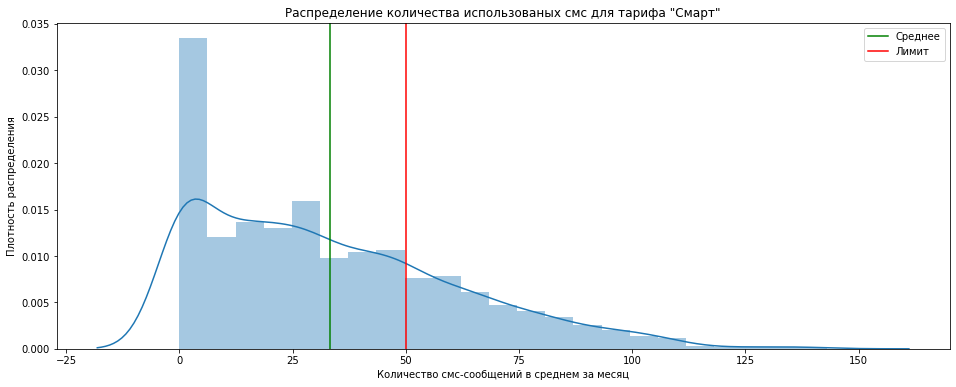

In [70]:
fig, ax = plt.subplots(figsize=(16,6))                                                                                        
sns.distplot(data_smart['messages_count']);
plt.axvline(x=data_smart['messages_count'].mean(), color='g', label='Среднее')
plt.axvline(x=50, color='r', label='Лимит')
ax.legend()
ax.set_title('Распределение количества использованых смс для тарифа "Смарт"');
plt.xlabel('Количество смс-сообщений в среднем за месяц');
plt.ylabel('Плотность распределения');
plt.show()

In [71]:
len(data_smart.query('messages_count <= 50'))/len(data_smart)

0.747085201793722

Распределение ближе к Пуассоновскому.
Большое количество людей в тарифе смарт особо не пользуется смс, в среднем люди отправляют 33 сообщения, что укладывается в лимит предоставленный в тарифе.
Но так же присуствуют пользователи, которым лимит маловат, но таких всего 25%
Основная масса людей, которым достаточно 50 сообщений

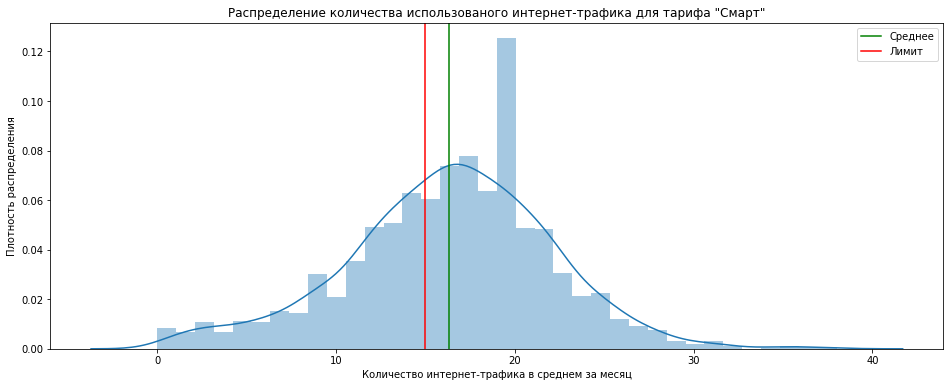

In [72]:
fig, ax = plt.subplots(figsize=(16,6))                                                                                        
sns.distplot(data_smart['gb_used']);
plt.axvline(x=data_smart['gb_used'].mean(), color='g', label='Среднее')
plt.axvline(x=15, color='r', label='Лимит')
ax.legend()
ax.set_title('Распределение количества использованого интернет-трафика для тарифа "Смарт"');
plt.xlabel('Количество интернет-трафика в среднем за месяц');
plt.ylabel('Плотность распределения');
plt.show()

In [73]:
len(data_smart.query('gb_used <= 15'))/len(data_smart)

0.41524663677130047

In [74]:
len(data_smart.query('total_rub > 1950'))/len(data_smart)

0.18699551569506725

График похож на нормальное распределение, есть пик на 20 гб, всего 41% клиентов укладывается в указанный лимит 15 гб интернет-трафика. Больше половины людей переплачивают круглую сумму за перерасход интернета. 
Почти 19% людей заплатили за услуги связи из-за привышения лимитов больше, чем пользователи тарифа ультра платят в месяц, укладываясь в лимиты.
Можно подробнее проанализировать данный показатель и предложить пользователям, другой тариф. 

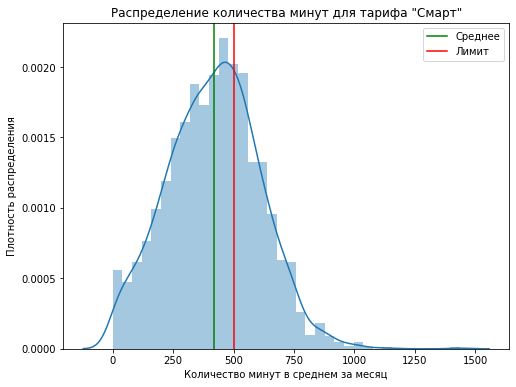

In [75]:
fig, ax = plt.subplots(figsize=(8,6))                                                                                        
sns.distplot(data_smart['calls_sum']);
ax.set_title('Распределение количества минут для тарифа "Смарт"');
plt.axvline(x=data_smart['calls_sum'].mean(), color='g', label='Среднее')
plt.axvline(x=500, color='r', label='Лимит')
ax.legend()
plt.xlabel('Количество минут в среднем за месяц');
plt.ylabel('Плотность распределения');
plt.show()

In [76]:
len(data_smart.query('calls_sum <= 500'))/len(data_smart)

0.6618834080717488

График так же похож на нормальное распределение со смещением в лево, здесь у нас уже больше людей укладывается в лимит по минутам включенным в тариф, но все так же присутсвует большое колчиство людей - 44%, которым не достаточно ограничения в 500 минут. 

### Анализ тарифа ultra

In [77]:
data_ultra_calculations = data_ultra.loc[:,'gb_used':'messages_count'].agg(
    ['mean', 'var', 'std']
)

In [78]:
data_ultra_calculations

,gb_used,calls_sum,calls_count,messages_count
mean,19.474645,526.089249,73.318458,49.313387
var,97.378544,101052.493549,1932.194928,2285.417425
std,9.868057,317.887549,43.956739,47.806040


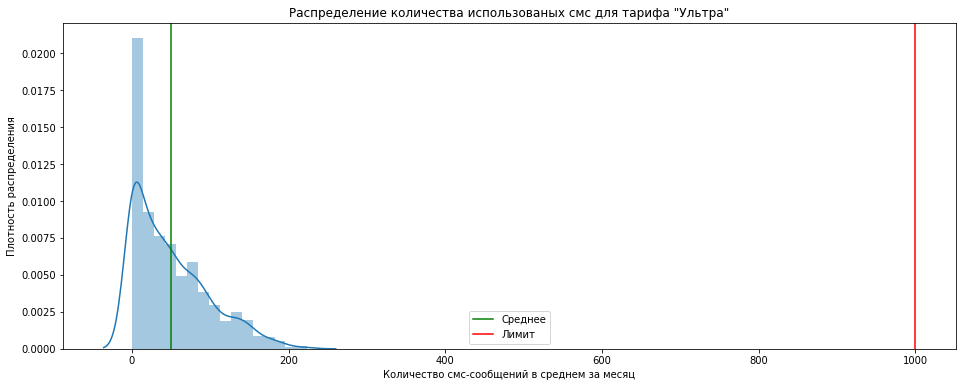

In [79]:
fig, ax = plt.subplots(figsize=(16,6))                                                                                        
sns.distplot(data_ultra['messages_count']);
plt.axvline(x=data_ultra['messages_count'].mean(), color='g', label='Среднее')
plt.axvline(x=1000, color='r', label='Лимит')
ax.legend()
ax.set_title('Распределение количества использованых смс для тарифа "Ультра"');
plt.xlabel('Количество смс-сообщений в среднем за месяц');
plt.ylabel('Плотность распределения');
plt.show()

В тарифе ультра, тук же как и в смарт - большое количество пользователей почти не пользуются смс. Это и логично, с наличием мессенджеров - смс стали почти не нужны.
На сколько мы видим по графику, абсолютно все укладываются в лимит в 1000 смс. В основном все значения ледат в пределе 200смс, лимит установлен уж слишком большим. Возможно было бы неплохо пересмотреть тариф ультра, т.к. на количество смс сейчас уже мало кто смотрит и такой большой лимит не зачем. Лучше заинтересовать пользователя количеством включенных гб интернета в тариф.

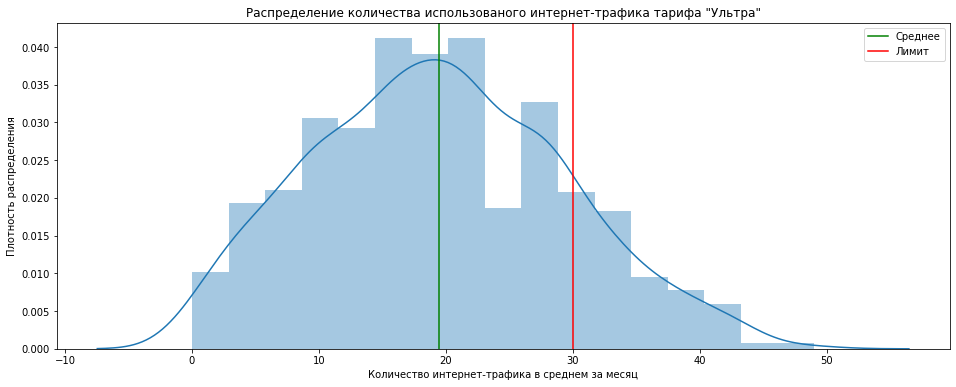

In [80]:
fig, ax = plt.subplots(figsize=(16,6))                                                                                        
sns.distplot(data_ultra['gb_used']);
plt.axvline(x=data_ultra['gb_used'].mean(), color='g', label='Среднее')
plt.axvline(x=30, color='r', label='Лимит')
ax.legend()
ax.set_title('Распределение количества использованого интернет-трафика тарифа "Ультра"');
plt.xlabel('Количество интернет-трафика в среднем за месяц');
plt.ylabel('Плотность распределения');
plt.show()

In [81]:
len(data_ultra.query('gb_used <= 30'))/len(data_ultra)

0.8640973630831643

График приближен к нормальному распределению со смещением влево.
86% клиентов укладываются в указанный лимит, но есть люди, которым недостаточно 30 гб.

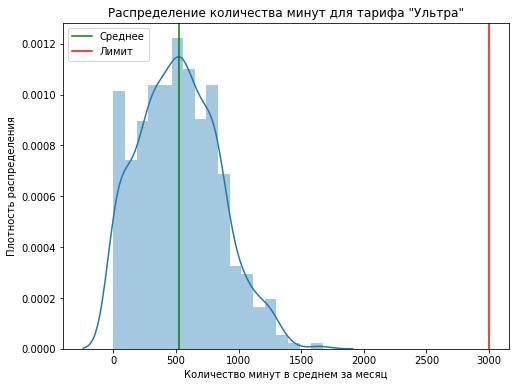

In [82]:
fig, ax = plt.subplots(figsize=(8,6))                                                                                        
sns.distplot(data_ultra['calls_sum']);
ax.set_title('Распределение количества минут для тарифа "Ультра"');
plt.axvline(x=data_ultra['calls_sum'].mean(), color='g', label='Среднее')
plt.axvline(x=3000, color='r', label='Лимит')
ax.legend()
plt.xlabel('Количество минут в среднем за месяц');
plt.ylabel('Плотность распределения');
plt.show()

Как мы видим на графике, все пользователи укладываются в отведенное количество минут в тарифе. Нет тех, кто разговаривал бы больше 50 часов в месяц по мобильному телефону.

### Анализ выручки

In [83]:
data_total_ultra = data_ultra[['total_rub']].agg(
    ['mean', 'var', 'std']
)
data_total_ultra.columns = ['total_ultra']

In [84]:
data_total_smart = data_smart[['total_rub']].agg(
    ['mean', 'var', 'std']
)
data_total_smart.columns = ['total_smart']

In [85]:
display(data_total_ultra, data_total_smart)

,total_ultra
mean,2070.030426
var,141387.714809
std,376.015578


,total_smart
mean,1289.641704
var,669730.763895
std,818.370799


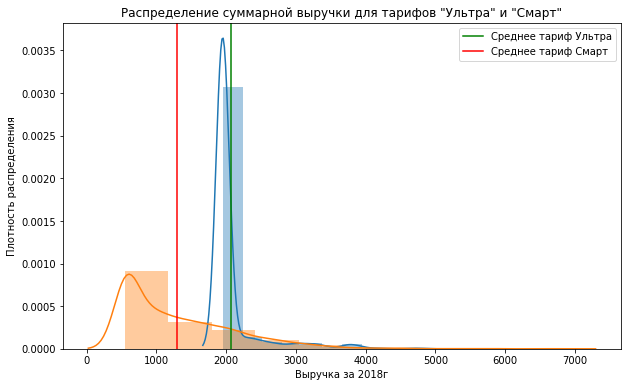

Cуммарная выручка тарифа Ультра 2041050.0
Cуммарная выручка тарифа Смарт 2875901.0


In [86]:
fig, ax = plt.subplots(figsize=(10,6))                                                                                        
sns.distplot(data_ultra['total_rub'], bins=10);
sns.distplot(data_smart['total_rub'], bins=10);
ax.set_title('Распределение суммарной выручки для тарифов "Ультра" и "Смарт"');
plt.axvline(x=data_ultra['total_rub'].mean(), color='g', label='Среднее тариф Ультра')
plt.axvline(x=data_smart['total_rub'].mean(), color='r', label='Среднее тариф Смарт')
ax.legend()
plt.xlabel('Выручка за 2018г');
plt.ylabel('Плотность распределения');
plt.show()

print('Cуммарная выручка тарифа Ультра', data_ultra['total_rub'].sum())
print('Cуммарная выручка тарифа Смарт', data_smart['total_rub'].sum())

В среднем пользователи тарифа ультра платят в месяц 2070 руб. Это чуть больше их месячной платы за тариф в 1950р. Пользователи этого тарифа укладываются в выделеные лимиты и редко переплаичают. Это же мы видим на синем графике.(среднее приходится на пик распределения 

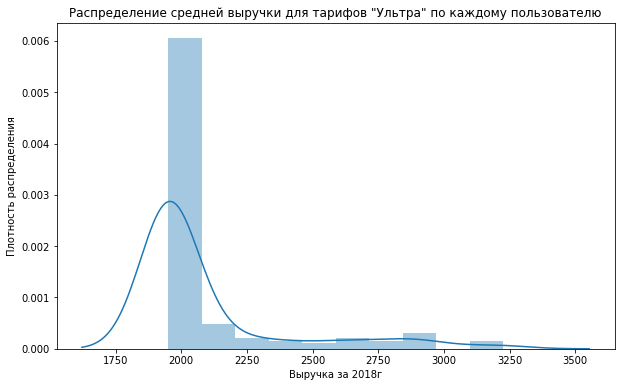

In [87]:
fig, ax = plt.subplots(figsize=(10,6)) 
sns.distplot(data_ultra.groupby('user_id')['total_rub'].mean(), bins=10);
ax.set_title('Распределение средней выручки для тарифов "Ультра" по каждому пользователю');
plt.xlabel('Выручка за 2018г');
plt.ylabel('Плотность распределения');

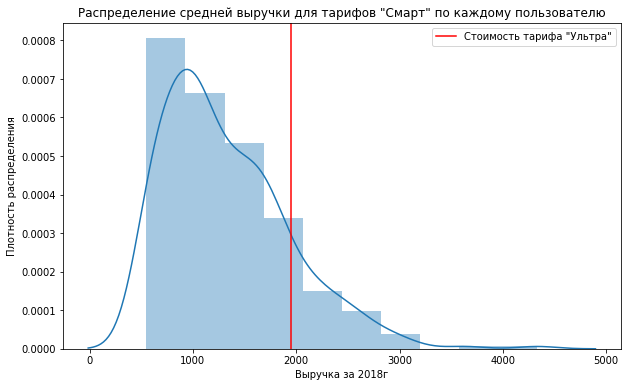

In [88]:
fig, ax = plt.subplots(figsize=(10,6)) 
a = data_smart.groupby('user_id',as_index=False)['total_rub'].mean()
sns.distplot(a['total_rub'], bins=10);
ax.set_title('Распределение средней выручки для тарифов "Смарт" по каждому пользователю');
plt.axvline(x=1950, color='r', label='Стоимость тарифа "Ультра"');
ax.legend();
plt.xlabel('Выручка за 2018г');
plt.ylabel('Плотность распределения');
plt.show()

In [89]:
a.query('1700 <= total_rub <= 2000')['user_id'].count()

33

У нас есть 33 пользователя, кто в среднем в месяц платить от 1700р до 2000р, данным пользователям модно предложить перейти на тариф Ультра, чтобы зафиксировать минимальный платеж в месяц. 

### Анализ доп. дохода от тарифов smart и ultra

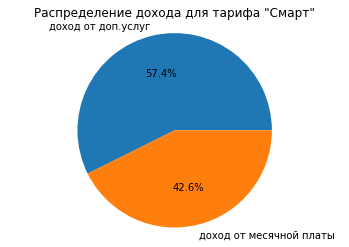

In [90]:
vals = [data_smart['profit_rub'].sum(), (data_smart['total_rub'].sum()-data_smart['profit_rub'].sum())]
labels = ["доход от доп.услуг", "доход от месячной платы"]
fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.1f%%')
ax.axis("equal")
ax.set_title('Распределение дохода для тарифа "Смарт"')
plt.show()

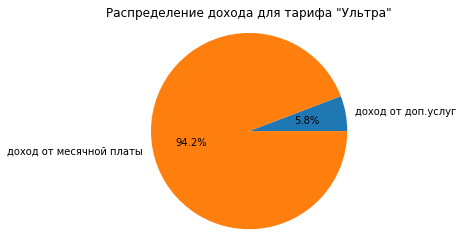

In [91]:
vals = [data_ultra['profit_rub'].sum(), (data_ultra['total_rub'].sum()-data_ultra['profit_rub'].sum())]
labels = ["доход от доп.услуг", "доход от месячной платы"]
fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.1f%%')
ax.axis("equal")
ax.set_title('Распределение дохода для тарифа "Ультра"')
plt.show()

Как мы видим из графиков, по тарифу Смарт 57% прибыли получается из-за привышения лимитов на связь. Данный показатель не стабилен и с таким распределением доходности сложно планировать прибыльность.
В тарифе ультра доход из-за привышения лимита приходится на 5%, вся остальная прибыль поступает от ежемесячной платы клиентов.

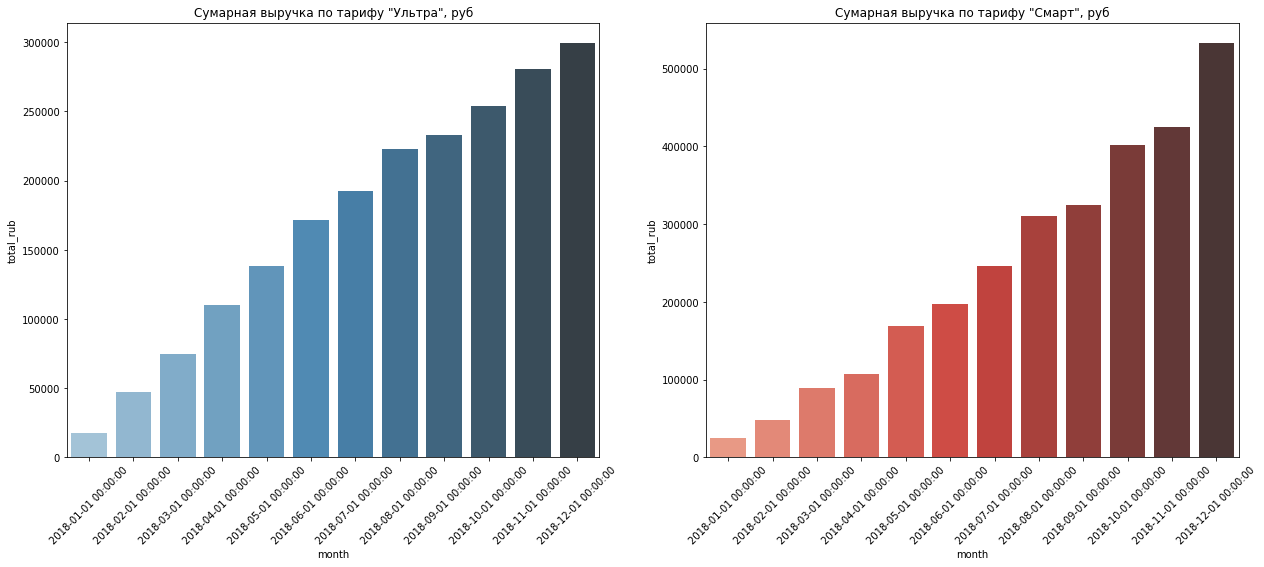

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(21,8))
plt.xticks(rotation = 45)
a = data_ultra.groupby('month')['total_rub'].agg('sum')
b = data_smart.groupby('month')['total_rub'].agg('sum')
sns.barplot(x=a.index, y=a, palette="Blues_d", ax=axes[0]) 
sns.barplot(x=b.index, y=b, palette="Reds_d", ax=axes[1])
axes[0].set_title('Cумарная выручка по тарифу "Ультра", руб');
axes[1].set_title('Сумарная выручка по тарифу "Смарт", руб');
axes[0].tick_params(axis='x', labelrotation = 45)
axes[1].tick_params(axis='x', labelrotation = 45)

Как мы видим по графикам доход по обоим тарифам растет, но тариф смарт показывает показатели лучше. Тариф ультра смог к концу года доползти до выручки в 300т руб, когда смарт показывал такие показатели уже в середине лета

## Шаг 4. Проверка гипотез

### средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Формируем гипотезу: Средняя выручка пользователей тарифов Ультра и Смарт - равна
Альтернативная гипотеза: Средняя выручка пользователей тарифов Ультра и Смарт - не равна

In [93]:

alpha = .05
results = st.ttest_ind(
    data_smart['total_rub'], 
    data_ultra['total_rub'],
    equal_var = False)

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.927011394420941e-250
Отвергаем нулевую гипотезу


Для проверки гипотезы был выбран t-тест Стьюдента, т.к. мы имеем две независимые друг от друга генеральные совокупности. Но т.к. выборки у нас разного размера, то решено было добавить параметр equal_var = False
Как вы видим из получившегося результата, мы можем отвергнуть нулевую гипотезу
Средняя выручка пользователей тарифов Ультра и Смарт - не равна, они отличаются

### средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Формируем гипотезу: Средняя выручка пользователей из Москвы и из других регионов - равна.
Альтернативная гипотеза: Средняя выручка пользователей из Москвы и из других регионов - не равна

In [94]:
data_msk = data.query("city == 'Москва'")

In [95]:
data_other_city = data.query("city != 'Москва'")

In [96]:
print('Количество пользователей из Москвы', len(data_msk))
print('Количество пользователей из других регионов', len(data_other_city))

alpha = .05
results = st.ttest_ind(
    data_msk['total_rub'], 
    data_other_city['total_rub'],
    equal_var = False)

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Количество пользователей из Москвы 611
Количество пользователей из других регионов 2605
p-значение: 0.5216952110000278
Не получилось отвергнуть нулевую гипотезу


Для проверки гипотезы был выбран t-тест Стьюдента, т.к. мы имеем две независимые друг от друга генеральные совокупности. Но т.к. выборки у нас разного размера, то решено было добавить параметр equal_var = False
Как мы видим из получившегося результата, мы  не можем отвергнуть нулевую гипотезу. Следовательно клиенты из Москвы приносят в среднем столько же денег компании, сколько и пользователи из других регионов. Но пользователетй из Москвы в несколько раз больше, чем из других регионов.

## Шаг 5. Вывод

Были изучены предоставленные данные сотового оператора «Мегалайн» за 2018 год 
Клиентам предлагают два тарифных плана: «Смарт» и «Ультра»
* в таблице users были оставленны только 3 стольцы user_id,city,tariff
* в таблице messages посчитали количество используемых сообщений у каждого клиента за каждый месяц
* в таблице internet посчитали количество используемого интернет-трафига у каждого клиента за каждый месяц. Параментр переведен в гигабайты и округлем в соответсвии с политикой компании.
* в таблице calls посчитали количество используемых минут у каждого клиента за каждый месяц. Округлен в соответсвии с политикой компании.
* данные во всех таблицах приведены к необходимым типам.
* таблицы объеденены в один датафрем для дальнейшего анализа.
* посчитана помесячная выручка по кажому клиенту
* посчитали среднее, дисперсию и стандартное отклонение по количеству смс, использоного интернет трафика и количества минут у тарифов смарт и ультра
* Проанализировали тарифы 

Смарт: пользователям не достаточно того лимита, который уставновлен в плане. Больше всего привышений по использованию интерент-трафика - 59% пользователей привысили лимит в 15 гб. 
44% людей привысили лимит по использованным минутам на звонки
И 25% людей привысили лимит в 50 смс сообщений.
Это все привело к тому, что итоговый доход от тарифа Смарт на 57% состоит из оплаты услуг сверх. лимита

Ультра: пользователи не привышают установленный лимит по смс и минутам на звонки. Но есть привышения использования интернет-трафика у 14% пользователей.
В тарифе ультра доход из-за привышения лимита приходится на 5%, вся остальная прибыль поступает от ежемесячной платы клиентов.

Доход по обоим тарифам растет, но тариф смарт показывает показатели лучше. Тариф ультра смог к концу года доползти до выручки в 300т руб, когда смарт показывал такие показатели уже в середине лета и к декабрю стал приносить 500т. р
Cуммарная выручка тарифа Ультра 2041050.0
Cуммарная выручка тарифа Смарт 2875901.0

* проверили гипотезу о различии средней выручки двух тарифов. Провели статистический тест с помощью t-теста Стьюдента. Получили статистически значимые различия двух средних.
* проверили гипотезу о различии средней выручки для пользователей из Москвы и для пользователей из других регионов. Статистически значимых различий между выручками пользователей нет.

Какой тариф лучше? 
Тариф Смарт показывает лучшую прибыль и хорошие темпы роста. В плане доходности он выигрывает у тарифа Ультра.

__Рекомендации__ Для улучшения продаж тарифа необходимо ввести 3 вариант, средний - т.к. по данным мы видим, что тариф Смарт слишком мал для среднего пользователя. А в тариф ультра включены мало используемые услуги в виде 1т сообщений и 50 часов разговоров.
А стоимость тарифов отличается в 3.5 раза.  